<h1 style='color: white'> About: Building a Restaurant Reccomendation system based on Yelp Reviews, Business Data and User Metadata </h1>

<h2><a href=https://www.kaggle.com/virajkadam/yelp-restaurants-eda-and-data-preparation>Link to the Data Processing and EDA notebook </a></h2>

# Imports

In [3]:
# general 
import pandas as pd 
import gc 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import pickle
import geopandas as gpd



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.metrics import accuracy_score


#deep learning 
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import backend as K 




pd.set_option('display.max_columns',None)

**Config**


**Random seed for reproduciblity**

In [4]:
class config:
    def __init__(self,
                seed=7,
                folds=15):
        self.seed = seed
        self.n_folds = folds
        
    def set_seed(self):
        '''set seed for reproduciblity'''

        tf.random.set_seed(self.seed)
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        np.random.seed(self.seed)
        print(f'Setting Random Seed  to {self.seed}')

        
        
cfg = config()
cfg.set_seed()

Setting Random Seed  to 7


# Helper Functions

In [5]:
def delete_items(items_list):
    
    try:
        for item in items_list:
            del item ; gc.collect()
            
    except Exception as e:
        print(e)

        
def save_pickle(path,
                file):
    
    with open(path) as f:
        pickle.dump(obj=path,
                   file = file)

# Loading Data 

In [6]:
#reviews 
reviews = pd.read_csv('../input/yelp-restaurants-eda-and-data-preparation/restaurant_reviews.csv') 

# restaurants data 
restaurants = pd.read_csv('../input/yelp-restaurants-eda-and-data-preparation/restaurants.csv')

# user metadata 
users = pd.read_csv('../input/yelp-restaurants-eda-and-data-preparation/users_metadata.csv')

In [7]:
reviews_user_matrix = reviews[['user_id','business_id','stars','year_over_base']].merge(users,on='user_id',how='left')


#yelping since is a year column, taking it as a difference over maximum
reviews_user_matrix['yelping_since']  = max(reviews_user_matrix['yelping_since']) - reviews_user_matrix['yelping_since']


# Splitting the data into Folds 


    1) Folds 1,2,3 are the validation sets in each of the training fold 
    2) randomly selecting 30,5581 as test set.

In [8]:
def split_df_in_folds(df,
                      n_folds=cfg.n_folds,
                      test_split=True,
                      test_fold_size=305580):
    '''split a dataset into folds for crossvalidation
    
    Outputs : validation_fold as fold number .'''
    
    if test_split:
        test_index = np.random.choice(a=len(df),
                                      size=test_fold_size)
        
        test_df = df.iloc[test_index]
        
        df.drop(test_index,axis=0,inplace=True)
        
    
    
    #split into folds
    df.reset_index(drop=True,inplace=True)
    cv = KFold(n_splits=n_folds,random_state=cfg.seed,shuffle=True)
    for fold,(tr,val_fold) in enumerate(cv.split(df)):
        
        df.loc[val_fold,'validation_fold'] = fold + 1
        
        
    if test_split:
        return df,test_df
    
    return df


In [9]:
#split the data into train and test set 

reviews_user_matrix,reviews_user_matrix_test = split_df_in_folds(reviews_user_matrix)


print(f'{len(reviews_user_matrix)} examples in train set. \n {len(reviews_user_matrix_test)} examples in test set')

4010685 examples in train set. 
 305580 examples in test set


In [10]:
delete_items([reviews,users])

# Standardizing Numerical Columns 

In [11]:
review_matrix_numerical_columns = ['year_over_base','review_count','yelping_since','useful','funny','cool','fans','average_stars','f_count']
restaurants_numerical_columns  = ['review_count','stars']

In [13]:
#scale
scaler = StandardScaler()
reviews_user_matrix[review_matrix_numerical_columns] = scaler.fit_transform(reviews_user_matrix[review_matrix_numerical_columns]) 

#storing mean and std devs 
review_numerical_transform_dict = {review_matrix_numerical_columns[i]:{'mean':scaler.mean_[i],'std':np.sqrt(scaler.var_[i])} for i in range(len(review_matrix_numerical_columns))}

In [14]:
def review_scaling_pipe(df,
                        scaling_values_dict=review_numerical_transform_dict):
    '''scales the test set data , from the mean ,stddev obtained on train set'''
    
    for key in scaling_values_dict.keys():
        df.loc[:,key] = (df.loc[:,key] -  scaling_values_dict[key]['mean'])/ scaling_values_dict[key]['std']  # x- mean / std
        
    return df

In [15]:
#scaling test data using train data params

reviews_user_matrix_test = review_scaling_pipe(reviews_user_matrix_test)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [16]:
scaler2 = StandardScaler()

restaurants[restaurants_numerical_columns] = scaler2.fit_transform(restaurants[restaurants_numerical_columns])#storing mean and std devs 
restaurants_numerical_transform_dict = {restaurants_numerical_columns[i]:{'mean':scaler2.mean_[i],
                                                                          'std':np.sqrt(scaler2.var_[i])} for i in range(len(restaurants_numerical_columns))}

# So, which Restaurant would you reccomend?

In [17]:
# names in restaurant and review clash for these 

restaurants.rename(columns={'stars':'mean_stars',     # mean rattings of restaurant 
                            'review_count':'reviews'},#count of reviews a rest has 
                   inplace=True) 

In [18]:
cfg.columns_info_dict = {'id_columns_user_matrix':['user_id','business_id'], # id cols  in user matrix 
                         'user_columns': [c for c in reviews_user_matrix.columns if c not in ['user_id','business_id','validation_fold','stars']], # training cols in user-matrix
                         'target': ['stars'],                        #target col
                         'id_columns': ['business_id','name'],               # id cols in restaurant 
                         'rest_columns':[c for c in restaurants.columns if c not in ['user_id','business_id','name']]} # trainig cols in restaurant matrix

In [19]:
from keras.utils.generic_utils import get_custom_objects


def rating_activation(x):
    
    #custom activation for rating in range(1-5)
    #     def act(x):
    return (K.sigmoid(x) * 4) + 1   # as sig is 0-1, our activation is bound in range[1-5]


get_custom_objects().update({'rating_activation': layers.Activation(rating_activation)})

# Nueral Net Based model 

    1) The model takes two inputs, 1) user-metadata matrix 2) The Business metadata matrix.
    
    2) These inputs are then projected in a lower dimensional space, and the outputs from them are added. 
    3) The dot product of the latent s

In [31]:


def build_nn_model(latent_space=30):
    
    # inputs
    user_inp = layers.Input(name = 'user_review', shape = (len(cfg.columns_info_dict['user_columns'])))
    rest_inp = layers.Input(name = 'restaurant', shape = (len(cfg.columns_info_dict['rest_columns'])))
    
    
    
    #generate user embeddings 
#     user= layers.Dense(128,name='user_hidden_1',activation='relu')(user_inp)
#     user = layers.BatchNormalization()(user)
#     user = layers.Dropout(0.5)(user)
    
    user= layers.Dense(64,name='user_hidden_2',activation='relu')(user_inp)
    user = layers.BatchNormalization()(user)
    user = layers.Dropout(0.5)(user)
    
    user= layers.Dense(latent_space,name='user_latent_space',activation='relu')(user)
    user = layers.BatchNormalization()(user)
    user = layers.Flatten()(user) #flatten
    
    
    #generate restaurant embeds 
    rest = layers.Dense(128,name='rest_hidden_1',activation='relu')(rest_inp)
    rest = layers.BatchNormalization()(rest)
    rest = layers.Dropout(0.5)(rest)
    
    rest = layers.Dense(512,name='rest_hidden_2',activation='relu')(rest)
    rest = layers.BatchNormalization()(rest)
    rest = layers.Dropout(0.5)(rest)
    
    rest = layers.Dense(128,name='rest_hidden_3',activation='relu')(rest)
    rest = layers.BatchNormalization()(rest)
    rest = layers.Dropout(0.5)(rest)
    
    rest = layers.Dense(latent_space,name='restaurant_latent_space',activation='relu')(rest)
    rest = layers.BatchNormalization()(rest)
    rest = layers.Flatten()(rest) #flatten
    
    dot = layers.Dot(name = 'dot_product', normalize = True, axes = - 1)([user, rest])
    
    add = layers.Add(name= 'addition_layer')([user,rest])
        
    # merged = dot * (add)
    merged = layers.Multiply(name='dot_mul_add')([dot,add])
    
    out = layers.Dense(5,activation='softmax',name='output_layer')(merged)
    
    # define the model
    model = tf.keras.Model(inputs = [user_inp, rest_inp], 
                           outputs = out)
    
    #compile
    model.compile(optimizer = 'Adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

    return model

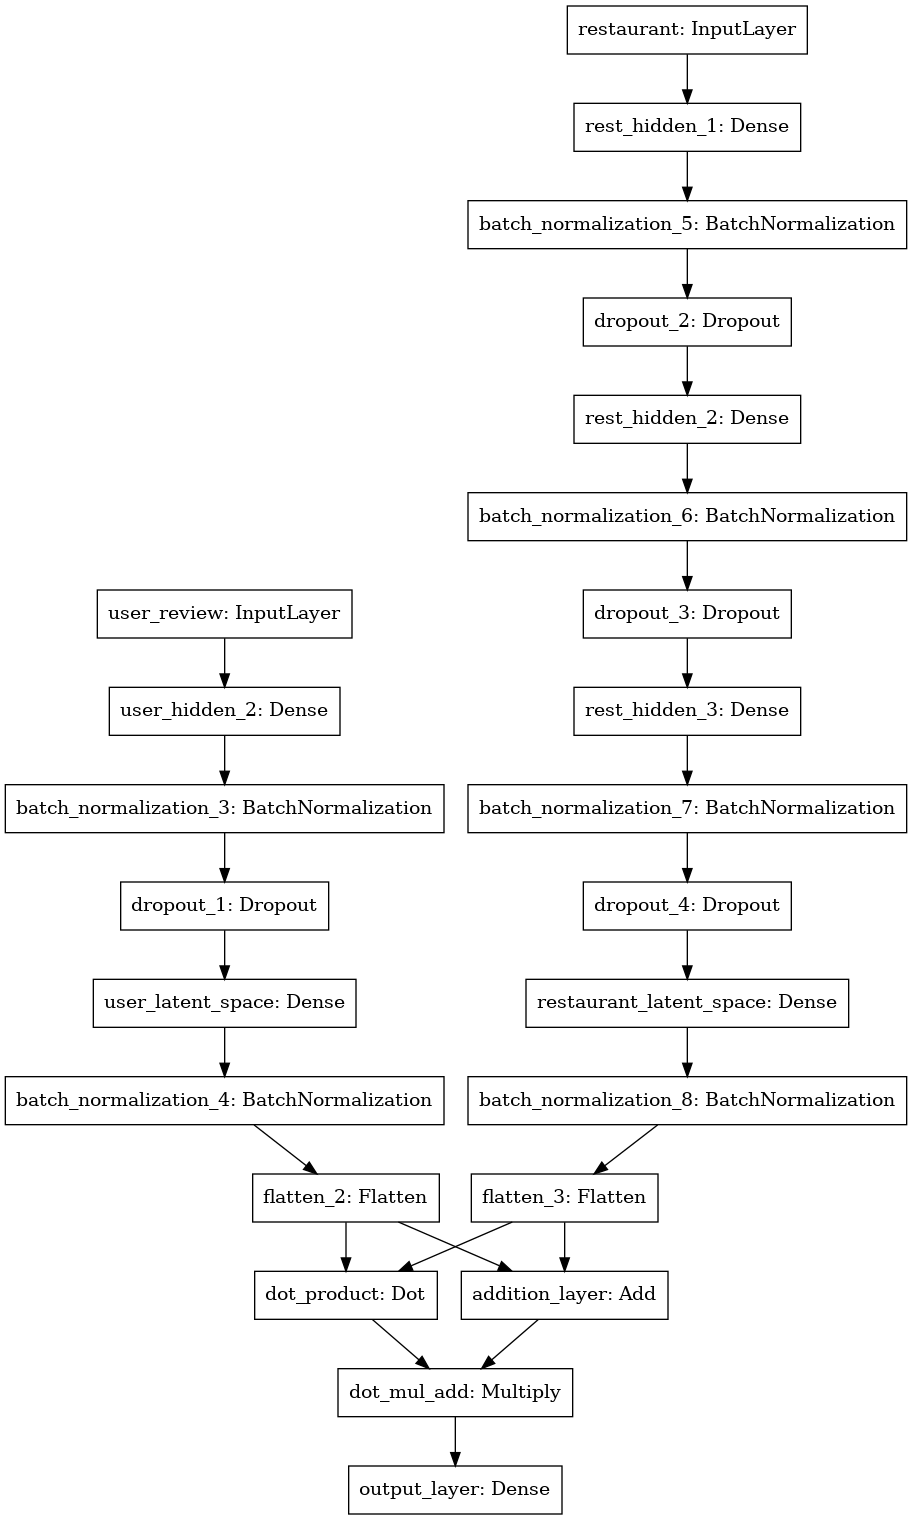

In [32]:
#build model 
model = build_nn_model()
cfg.batch_size = 128

tf.keras.utils.plot_model(model)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
restaurant (InputLayer)         [(None, 1100)]       0                                            
__________________________________________________________________________________________________
rest_hidden_1 (Dense)           (None, 128)          140928      restaurant[0][0]                 
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 128)          512         rest_hidden_1[0][0]              
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 128)          0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

# Because the dataset is quite large, training in parts 

In [34]:
def get_dummies(array,
                n=5):
    ohe_array= np.zeros(shape= (len(array),n))
    
    for i,rating in enumerate(array):
        ohe_array[i,rating-1] = 1
        
    return ohe_array

def prepare_data_for_training(df):
    '''prepare data to feed in nn'''
    df = df.merge(restaurants,on='business_id',how='left')                     # join business columns
    
    df.reset_index(drop=True,inplace=True)
    
    
    user_review_mat = df.loc[:,cfg.columns_info_dict['user_columns']].values.astype('float32') # user - review matrix
    restaurant_mat = df.loc[:,cfg.columns_info_dict['rest_columns']].values.astype('float32')   # restaurant matrix
    target = np.squeeze(df.loc[:,cfg.columns_info_dict['target']].values,axis=-1)                   #target
    
    #one hot encode target 
    target = get_dummies(target)
        
    del df ; gc.collect()
    
    return user_review_mat,restaurant_mat,target

In [35]:
def training_loop(
                  num_epochs_per_fold = 1,
                  num_repeats = 2,
                  verbose=1):
    
    for i in range(num_repeats):
        print(f'Lap {i+1}')
        num_epochs_per_fold += 1
        
        for fold in range(1,cfg.n_folds+1):
            df=reviews_user_matrix[reviews_user_matrix['validation_fold']==fold].copy(deep=True)
            user_review_mat,restaurant_mat,target = prepare_data_for_training(df)  # select fold for training
            
            del df;gc.collect()
            
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                             monitor='val_loss',
                                                             factor=0.50,
                                                             mode='min',
                                                             verbose=1)
            _=model.fit([user_review_mat,restaurant_mat],
                        target,
                        epochs=num_epochs_per_fold,
                        batch_size = cfg.batch_size,
                        verbose=verbose,
                        validation_split=0.2,
                        callbacks= [reduce_lr],
                        validation_freq=2)

            #delete items from memory 
            delete_items([user_review_mat,restaurant_mat,target])

In [36]:
#run the training loop
training_loop()

Lap 1
Epoch 1/2
1672/1672 [==============================] - 25s 13ms/step - loss: 1.3244 - accuracy: 0.4439
Epoch 2/2
1672/1672 [==============================] - 26s 15ms/step - loss: 1.2180 - accuracy: 0.4909 - val_loss: 1.2166 - val_accuracy: 0.4909
Epoch 1/2
1672/1672 [==============================] - 23s 14ms/step - loss: 1.2056 - accuracy: 0.4971
Epoch 2/2
1672/1672 [==============================] - 24s 14ms/step - loss: 1.1951 - accuracy: 0.5018 - val_loss: 1.1739 - val_accuracy: 0.5108
Epoch 1/2
1672/1672 [==============================] - 24s 14ms/step - loss: 1.1872 - accuracy: 0.5060
Epoch 2/2
1672/1672 [==============================] - 27s 16ms/step - loss: 1.1811 - accuracy: 0.5067 - val_loss: 1.1781 - val_accuracy: 0.5023
Epoch 1/2
1672/1672 [==============================] - 23s 14ms/step - loss: 1.1811 - accuracy: 0.5056
Epoch 2/2
1672/1672 [==============================] - 25s 15ms/step - loss: 1.1781 - accuracy: 0.5076 - val_loss: 1.1639 - val_accuracy: 0.5158
Ep

**Predict on Test set**

In [61]:
def test_predict(model,evaluate=True,predict=False):
    user_test,rest_test,target_test = prepare_data_for_training(reviews_user_matrix_test)
    
    if evaluate:
        model.evaluate([user_test,rest_test])
    
    if predict:
        prediction = model.predict([user_test,rest_test])
        
        delete_items([user_test,rest_test,target_test])
        return prediction
    
    
    delete_items([user_test,rest_test,target_test])
    
    
#predict on the test set 
prediction = 1 + test_predict(model=model,evaluate=False,predict=True).argmax(axis=1)  # as it is indexed from 0 

# Some Reccomendations then? 

# The recommeder system works as follows: 

* Find the closest 15 restaurants based on user location (which is estimated by user interaction with other restaurants).
* predict the rating the user will give each of that 15 restaurant based on user and restaurant matrix.

In [38]:
#filter based on location 
from shapely.geometry import Point
import re

business = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_business.json',
                        lines=True)


#finding restaurants restaurants
business['restaurant'] = (business.categories.str.contains(pat='Restaurant',
                                                          flags=re.IGNORECASE,
                                                          regex=True))

#saving restaurants  as csv 
rests = business[(business.restaurant==1) & (business.is_open==1)].reset_index(drop=True)

loc_cols = ['business_id','latitude','longitude']


rests= rests[loc_cols]


locations = gpd.GeoDataFrame(rests)
locations.geometry = gpd.points_from_xy(locations['latitude'],locations['longitude'])


del business ,rests; gc.collect()

41

In [55]:
def reccomender(user_id):
    '''filtering based on user location and recom top 15 restaurants'''
    #get info for the user 
    user_matrix = reviews_user_matrix[reviews_user_matrix['user_id']==user_id].reset_index(drop=True)
    
    # business that user has interacted with: (to find the location of user)
    user_interaction_business = user_matrix['business_id']
    
    user_loc_mean = Point(locations[locations['business_id'].isin(user_interaction_business)]['latitude'].mean(),
                     locations[locations['business_id'].isin(user_interaction_business)]['longitude'].mean())
    
    #calculate the closest 20 restaurants to user 
    
    closest_10 = np.argsort(locations.geometry.distance(user_loc_mean))[:15]
    
    for idx in closest_10:
        user = user_matrix.loc[0,cfg.columns_info_dict['user_columns']].values.astype('float32')
        business = restaurants.loc[idx,cfg.columns_info_dict['rest_columns']].values.astype('float32')
        rest_name = restaurants.iloc[idx]['name']
        
#         print(rest_name,user.shape,business.shape)
        pred = model.predict([np.expand_dims(user,axis=0),np.expand_dims(business,axis=0)]).argmax()
        print(f'{rest_name} is recommended with rating  ', pred)
    
    
    
    
# recommending for user 
reccomender('SFQ1jcnGguO0LYWnbbftAA')

Tortilleria & Restaurant La Mexicana is recommended with rating   3
King Express is recommended with rating   3
Anf Gyros and Grill is recommended with rating   3
Taqueria el alacran 2 orlando is recommended with rating   4
New Texas Fried Chicken is recommended with rating   3
China Sun is recommended with rating   3
Casa De Las Empanadas is recommended with rating   3
Panaderia Y Taqueria Casas is recommended with rating   4
Pizza Hut is recommended with rating   0
Tai Won Restaurant is recommended with rating   3
Five Star Orlando VIP Tours is recommended with rating   4
Burger King is recommended with rating   0
Shang Hai is recommended with rating   3
Little Caesar's Pizza is recommended with rating   3
La Casita Pupusas & Latin Food is recommended with rating   4


In [56]:
# recommending for user 
reccomender('xpxWG7jQXZE6BcSeuIq4PQ')

Chatham's Place is recommended with rating   4
Team Donovan is recommended with rating   4
The Whiskey is recommended with rating   4
Tropical Smoothie Cafe is recommended with rating   4
Ayothaya Thai Restaurant is recommended with rating   3
Starbucks is recommended with rating   4
LemonShark Poke Orlando is recommended with rating   4
Chipotle Mexican Grill is recommended with rating   3
Einstein Bros Bagels is recommended with rating   4
The Melting Pot is recommended with rating   4
Korean Gogi Grill is recommended with rating   4
K-Town Cafe is recommended with rating   4
TooJay's is recommended with rating   4
Extreme Pizza is recommended with rating   4
Steak on Fire is recommended with rating   4


In [58]:
# recommending for user 
reccomender('IlxM3NGJOtNXPz5cupqNDQ')

Thai Yummy is recommended with rating   4
Tasty Thai Cuisine is recommended with rating   4
Oak & Olive Ristorante is recommended with rating   4
Verde Cocina - Hillsdale is recommended with rating   4
Verde Cocina is recommended with rating   4
Sasquatch Brewery is recommended with rating   4
Salvador Molly's is recommended with rating   4
City Thai Portland is recommended with rating   4
Vista Spring Cafe is recommended with rating   4
Jade Dragon Chinese Restaurant & Lounge is recommended with rating   0
Joseph & Brian's Diner is recommended with rating   4
Cafe at the J is recommended with rating   4
Casa Colima is recommended with rating   4
Papa John's Pizza is recommended with rating   0
McMenamins Hillsdale Brewery & Public House is recommended with rating   0


In [60]:
# recommending for user 
reccomender('HsT8bz3-SKMk7YidwLLM6Q')

Dish Gourmet is recommended with rating   3
Scratch Kitchen is recommended with rating   3
Mateo is recommended with rating   3
Cured is recommended with rating   4
River and Woods is recommended with rating   3
Frasca Food and Wine is recommended with rating   4
The Tune Up is recommended with rating   4
Pizzeria Locale is recommended with rating   3
Leaf Vegetarian Restaurant is recommended with rating   3
Snarfburger is recommended with rating   3
Tacos Del Norte is recommended with rating   4
La Rue Bayou is recommended with rating   4
The Laughing Goat is recommended with rating   3
Arabesque is recommended with rating   3
Village Coffee Shop is recommended with rating   4


# References and Resources 
* https://www.kaggle.com/willkoehrsen/neural-network-embedding-recommendation-system
* https://www.kaggle.com/zolboo/recommender-systems-knn-svd-nn-keras